In [1]:
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sea
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline as pipe

from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import KFold
import lightgbm as lgb
from lightgbm import LGBMRegressor
import optuna
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
eps = 1e-7
logit   = lambda p: np.log(np.clip(p, eps, 1-eps) / (1 - np.clip(p, eps, 1-eps)))
sigmoid = lambda x: 1/(1 + np.exp(-x)) 
RMSE    = lambda y_true, y_pred: np.sqrt(np.mean((y_true - y_pred)**2))

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
test  = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e10/sample_submission.csv")

In [4]:
train_pd = train.drop(columns=["id"])
bool_features = ["road_signs_present", "public_road", "holiday", "school_season"]


X = train_pd.copy()
X[bool_features] = X[bool_features].astype(np.uint8)
X["num_lanes"] = X["num_lanes"].astype(object)

y = X.pop("accident_risk")
y_logit = logit(y)

In [5]:
def cross_validate(model, X, y_logit, n_splits=10, store_oof=True, save_n_models=False, model_prefix=None):
    kfold = KFold(n_splits=n_splits, random_state=3126, shuffle=True)
    rmse  = np.zeros(n_splits)
    if store_oof:
        y_oof = np.zeros_like(y_logit)
    history = {}
    
    for k,(train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train, y_train = X.iloc[train_idx], y_logit[train_idx]
        X_val,   y_val   = X.iloc[val_idx],   y_logit[val_idx]
        
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        if save_n_models:
            model_filename = f"{model_prefix}_{k+1}.joblib"
            joblib.dump(cloned_model, model_filename)
            
        ## Get logit predictions
        y_pred = cloned_model.predict(X_val)
        ## If store_oof is enabled, stores the oof prediction
        if store_oof:
            y_oof[val_idx] = y_pred
        ## Stores RMSE
        rmse[k] = RMSE(sigmoid(y_val), sigmoid(y_pred))      
            
    history["rmse"] = rmse
    if store_oof:
        history["y_oof"] = y_oof
    return history

In [6]:
cat_features = ['road_type', 'lighting', 'weather', 'time_of_day', "num_lanes"]
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(drop="first"), cat_features)],
    remainder="passthrough",
    n_jobs=-1
)

lgbm_params = {
    'max_depth': 8, 
    'learning_rate': 0.0034644899550239795, 
    'n_estimators': 1831, 
    'min_child_samples': 232, 
    'min_child_weight': 5.532429876763161e-05, 
    'min_split_gain': 0.029461312897567815, 
    'reg_alpha': 0.019901461024258202, 
    'reg_lambda': 0.0412759418014411, 
    'colsample_bytree': 0.7538390698790997, 
    'subsample': 0.9867289720760068, 
    'max_bin': 319, 
    'num_leaves': 153
}
lgbm_params["verbose"] = -1
lgbm_params["random_state"] = 3126
lgbm_params["n_jobs"] = -1
lgbm_params["device"] = "gpu"

model = pipe(preprocessor, LGBMRegressor(**lgbm_params))
history = cross_validate(model, X, y_logit, n_splits=10, store_oof=True, save_n_models=True, model_prefix="lgbm")

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


In [7]:
history["rmse"].mean()

0.05717078045764359

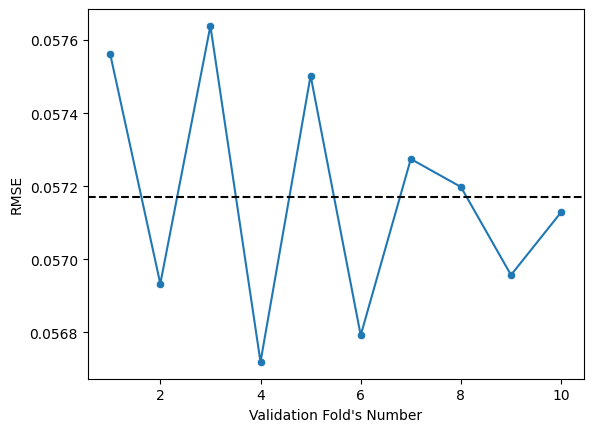

In [8]:
sea.scatterplot(x=np.arange(1,11), y=history["rmse"])
sea.lineplot(x=np.arange(1,11), y=history["rmse"])
plt.axhline(y=history["rmse"].mean(), color="black", linestyle="dashed")
plt.xlabel("Validation Fold's Number")
plt.ylabel("RMSE")
plt.show()

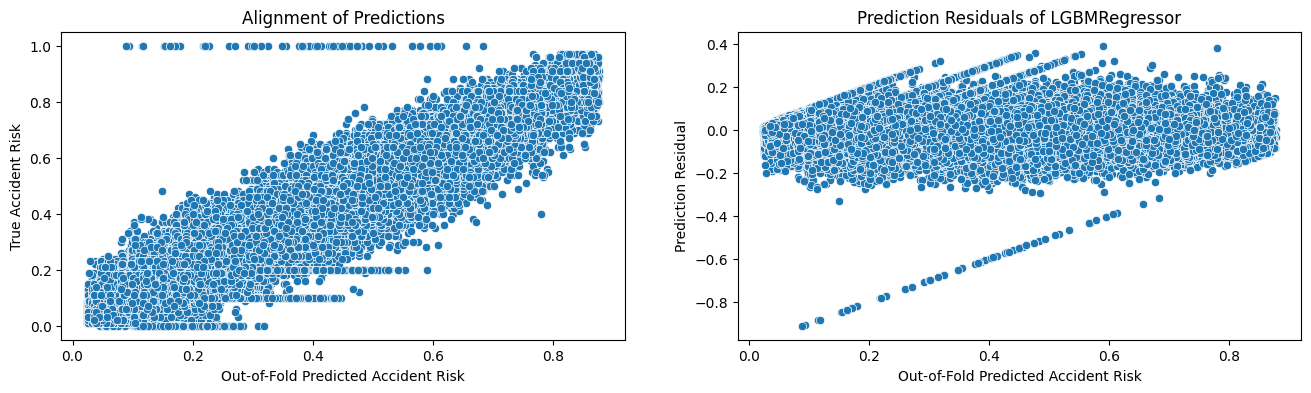

In [9]:
plt.figure(figsize=(16,4))
plt.subplot(121)
sea.scatterplot(x=sigmoid(history["y_oof"]), y=y)
plt.xlabel("Out-of-Fold Predicted Accident Risk")
plt.ylabel("True Accident Risk")
plt.title("Alignment of Predictions")

plt.subplot(122)
sea.scatterplot(x=sigmoid(history["y_oof"]), y=sigmoid(history["y_oof"])-y)
plt.xlabel("Out-of-Fold Predicted Accident Risk")
plt.ylabel("Prediction Residual")
plt.title("Prediction Residuals of LGBMRegressor")

plt.show()

In [10]:
model = pipe(preprocessor, LGBMRegressor(**lgbm_params))
model.fit(X, y_logit)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['road_type', 'lighting',
                                                   'weather', 'time_of_day',
                                                   'num_lanes'])])),
                ('lgbmregressor',
                 LGBMRegressor(colsample_bytree=0.7538390698790997,
                               device='gpu',
                               learning_rate=0.0034644899550239795, max_bin=319,
                               max_depth=8, min_child_samples=232,
                               min_child_weight=5.532429876763161e-05,
                               min_split_gain=0.029461312897567815,
                               n_estimators=1831, n_jobs=-1, num_leaves=153,
                               random_state=3126,
                               reg_alpha=0.019901461024258202,
                               reg_lambda=0.0412759418014411,
                               subsample=0.9867289720760068, verbose=-1))])

In [11]:
model = pipe(preprocessor, LGBMRegressor(**lgbm_params))
model.fit(X, y_logit)
lgbm = model[-1]
feature_names = model.named_steps["columntransformer"].get_feature_names_out()

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": lgbm.feature_importances_/lgbm.feature_importances_.sum()
}).sort_values(by="Importance", ascending=False)

print(feat_imp.head(20))

                              Feature  Importance
11               remainder__curvature    0.398737
17  remainder__num_reported_accidents    0.118677
12             remainder__speed_limit    0.082627
4          categorical__weather_foggy    0.056062
5          categorical__weather_rainy    0.055952
2           categorical__lighting_dim    0.049135
15                 remainder__holiday    0.042732
14             remainder__public_road    0.039574
6    categorical__time_of_day_evening    0.028391
9            categorical__num_lanes_3    0.019887
10           categorical__num_lanes_4    0.019823
13      remainder__road_signs_present    0.018597
3         categorical__lighting_night    0.017416
7    categorical__time_of_day_morning    0.016182
1        categorical__road_type_urban    0.014073
0        categorical__road_type_rural    0.011866
16           remainder__school_season    0.006380
8            categorical__num_lanes_2    0.003890


In [12]:
# plt.figure(figsize=(16,10))
# plt.subplot(321)
# sea.scatterplot(x=train["curvature"], y=train["accident_risk"], hue=train["num_reported_accidents"], alpha=.25)
# plt.title("Original curvature")
# plt.xlabel("")

# plt.subplot(322)
# sea.scatterplot(x=train["curvature"]**2, y=train["accident_risk"], hue=train["num_reported_accidents"], alpha=.25)
# plt.title("Squared curvature")
# plt.xlabel("")

# plt.subplot(323)
# sea.scatterplot(x=train["curvature"]**3, y=train["accident_risk"], hue=train["num_reported_accidents"], alpha=.25)
# plt.title("Cubed curvature")
# plt.xlabel("")

# plt.subplot(324)
# sea.scatterplot(x=np.sqrt(train["curvature"]), y=train["accident_risk"], hue=train["num_reported_accidents"], alpha=.25)
# plt.title("Sqrt curvature")

# plt.subplot(325)
# sea.scatterplot(x=np.log1p(train["curvature"]), y=train["accident_risk"], hue=train["num_reported_accidents"], alpha=.25)
# plt.title("Log curvature")
# plt.show()

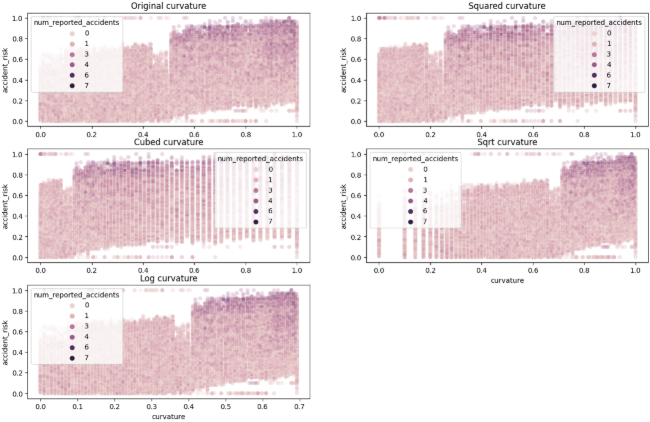

In [13]:
test.drop(columns=["id"], inplace=True)

bool_features = ["road_signs_present", "public_road", "holiday", "school_season"]
test[bool_features] = test[bool_features].astype(np.uint8)
test["num_lanes"] = test["num_lanes"].astype(object)

In [14]:
y_pred = np.zeros(len(test))

for k in range(1, 11):
    model = joblib.load(f"/kaggle/working/lgbm_{k}.joblib")
    y_pred += sigmoid(model.predict(test))
y_pred /= 10

In [15]:
sample_submission["accident_risk"] = y_pred

In [16]:
sample_submission.to_csv("submission.csv", index=False)